In [1]:
#DEPENDENCIES 
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn import preprocessing
pd.set_option('display.max_columns', 50)

from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.cross_validation import cross_val_score, cross_val_predict
import statsmodels.api as sm
from scipy import stats
import scipy.stats as ss
from statsmodels.graphics.gofplots import qqplot
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Preprocessing & Feature Engineering

In [2]:
df = pd.read_csv('kc_house_data.csv', sep=',')
df['sqft_above'] = df['sqft_above'].fillna(df['sqft_above'].mean()) #fill 2 missing sqft_above values with mean of column
print('Dimensions of raw data: ' + str(df.shape))
target = df.loc[:,'price']
target_log = np.log(target)

df.head(10)

Dimensions of raw data: (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890.0,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715.0,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060.0,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050.0,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,1890.0,0,2003,0,98038,47.3684,-122.031,2390,7570


## 1.) Create a synthetic categorical feature (cluster zipcodes by avg price)

In [3]:
#zipcode cluster by average home price, generated with Tableau
zipcode_clusters = pd.read_csv('zipcode_clusters.csv', sep=',') #CSV output of Tableau clustering model

zipcode_clusters = zipcode_clusters.replace(
    {'Cluster 5':5,'Cluster 4':4,'Cluster 3':1,'Cluster 2':2,'Cluster 1':3}) #replace cluster strings w appropriate ordinal ints
#the cluster numbers assigned by Tableau were mismatched with the sorted average values
display(zipcode_clusters.head())

,Clusters,Zipcode,Avg. Price
0,1,98002,"234,284.04"
1,1,98168,"240,328.37"
2,1,98032,"251,296.24"
3,1,98001,"280,804.69"
4,1,98148,"284,908.60"


In [4]:
#Use mapping table of zipcodes and assigned cluster to add new 'zipcode_cluster' variable to dataframe
zipcodes = list(df.loc[:,'zipcode'])

clusters = list(zipcode_clusters.loc[:,'Clusters'])
zipcode_maps = list(zipcode_clusters.loc[:,'Zipcode'])
cluster_tups = list(zip(zipcode_maps,clusters))

for idx,code in enumerate(zipcodes):
    for tup in cluster_tups:
        if code == tup[0]: #if the zipcode in the full dataframe matches the zipcode in the cluster mapping table
            zipcodes[idx] = tup[1] #then update the zipcode in the full dataframe with the cluster value

zipcode_cluster_val = pd.Series(data=zipcodes) #convert back to a Series so it can be added to dataframe
zipcode_cluster_val.reset_index(drop=True, inplace=True)

#df_ denotes an 'intermediary' dataframe to work with in memory - not the raw data, but not fully cleaned either
df = pd.concat([df,zipcode_cluster_val], axis=1)
df = df.rename(columns = { 0 : 'zipcode_cluster'})

zip_cluster = df.loc[:,'zipcode_cluster']

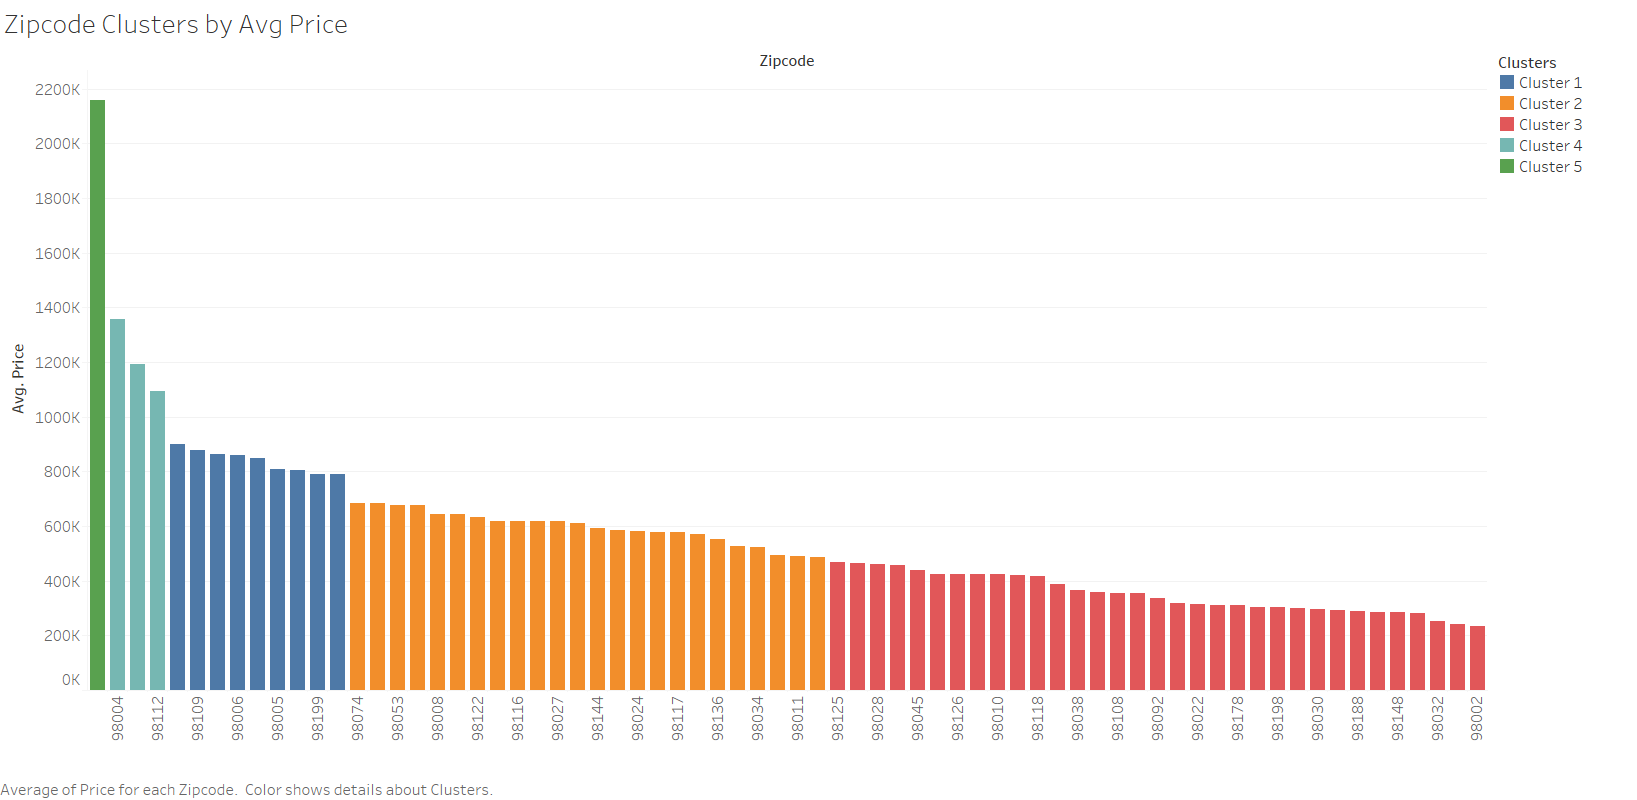

## 2.) One-hot encode categorical variables & prepare data for SAS

In [5]:
nominal_features = df.loc[:,['waterfront','view']] #exclude zipcode since it is being transformed into cluster values

#encode nominal categorical vars using one-hot encoding
cat_dummies = pd.get_dummies(nominal_features.astype('category'),drop_first=True) #drop first to reduce multicollinearity

    
#CONVERT YR_RENOVATED TO A BINARY VARIABLE
yr_renovated = list(df.loc[:,'yr_renovated'])
renovated = [] #list to store binary variable 'renovated' (1 if renovated, 0 if not)
for row in yr_renovated:
    if row == 0:
        renovated.append(0)
    else:
        renovated.append(1)
renovated = pd.Series(data=renovated)
df['renovated'] = renovated

continuous_features = df.loc[:,['bedrooms','bathrooms','sqft_living', 
                             'sqft_lot','sqft_basement','yr_built','condition','grade']]


#RESET INDEXES OF DATAFRAMES SO THEY CAN BE PROPERLY CONCATENATED
target_log.reset_index(drop=True, inplace=True)
zip_cluster.reset_index(drop=True, inplace=True)
cat_dummies.reset_index(drop=True, inplace=True)
renovated.reset_index(drop=True, inplace=True)
continuous_features.reset_index(drop=True, inplace=True)

#concatenate everything into a fully preprocessed dataframe to be read into SAS
clean_df = pd.concat([target_log, continuous_features, renovated, zip_cluster, cat_dummies],axis=1)
clean_df = clean_df.rename(columns = { 0 : 'renovated'})
clean_df.head()

clean_df.to_csv('clean_data.csv')

#### 2.1) *******Run Principal Component Analysis in SAS******** 

## 3.) Split PCA data into training and testing sets 

In [6]:
pca = pd.read_csv('clean_pca.csv',sep=',') #read PCA data generated from SAS
pca.head()

target = pca.loc[:,'price']
princomps = pca.iloc[:,17:]
categories = pca.iloc[:,12:17]
renovated = pca.loc[:,'renovated']
features = pd.concat([princomps,categories,renovated], axis=1)
features.head()

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size= 0.25, random_state=5) 
#train on 75% of data, test on 25%

train = pd.concat([X_train,y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

#### 3.1) Run an initial regression model in SAS to determine influential observations 

## 4.) Identify & Remove Influential Observations after initial SAS regression

In [11]:
#influence statistics from SAS regression model
influence = pd.read_csv('influence.csv', sep=',') #influence statistics for each record in the training dataset
display(influence.head())

influence = influence.loc[:,['cooksd','lev','dffits']]


high_lev_points = influence.loc[influence['lev'] > (2*12/train.shape[0])]
high_lev_points = high_lev_points.index.values
print('# of high leverage points: ' + str(len(high_lev_points)))

high_cooksd = influence.loc[influence['cooksd'] > (4/train.shape[0])]
high_cooksd = high_cooksd.index.values
print('# of high cooksd points: ' + str(len(high_cooksd)))

high_dffits = influence.loc[influence['dffits'] > (2*sqrt(12+1) / sqrt(train.shape[0] - 12 - 1))]
high_dffits = high_dffits.index.values
print('# of high dffits points: ' + str(len(high_dffits)))


        
print('\n')
influentials = [x for x in high_lev_points if x in high_cooksd and x in high_dffits]
print('# of influential points: ' + str(len(influentials)))

,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6,Prin7,Prin8,Prin9,waterfront_1,view_1,view_2,view_3,view_4,renovated,price,cooksd,lev,dffits
0,1.025933,-0.986926,0.259021,0.334555,0.179463,-0.706452,0.390723,-0.013227,-0.067330,0,0,0,0,0,0,13.299672,0.000006,0.000213,0.008830
1,0.915003,-0.989288,2.044399,1.465127,-0.087530,-1.023789,0.619511,0.176392,0.138924,0,0,0,0,0,0,13.388566,0.000048,0.000724,0.025096
2,1.055327,0.870833,-1.452691,2.399647,0.906401,-0.104049,0.026824,0.071126,-0.219734,0,0,0,0,0,0,13.805460,0.000028,0.000670,-0.019224
3,-0.029982,-0.714146,0.366049,-1.359226,0.169853,-1.581008,0.303203,0.273610,0.043614,0,0,0,0,0,0,12.730801,0.000006,0.000485,0.008456
4,-1.417197,-0.382646,-0.598516,0.750037,-0.403010,-0.548387,-0.447774,0.848406,0.476363,0,0,0,0,0,0,12.916568,0.000001,0.000342,-0.004071


# of high leverage points: 2243
# of high cooksd points: 911
# of high dffits points: 466


# of influential points: 361


In [9]:
#REMOVE INFLUENTIAL POINTS FROM TRAINING DATA
train = train.drop(train.index[influentials])

#WRITE CLEAN TRAINING DATA WITH NO INFLUENTIALS TO CSV - INPUT THIS TO A NEW SAS REGRESSION MODEL
train.to_csv('train_no_influentials.csv', index=False)